In [76]:
import sys
import platform
import json
import pickle
import time
import itertools

from wordcloud import WordCloud
from pathlib import Path
import tweepy
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import gmplot
import matplotlib.pyplot as plt

import configparser

tweepy.debug(True) # show the rate limit information

DATA_DIR = Path('data')
RESULTS_PER_QUERY = 100 

import seaborn as sns
sns.set()
sns.set_style('darkgrid')


# needed for .parquet files
!pip install pyarrow 
!pip install jupyternotify
# import nltk
# nltk.download('wordnet')

%load_ext jupyternotify

Error processing line 7 of c:\users\tommy\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "c:\users\tommy\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


Error processing line 7 of c:\users\tommy\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "c:\users\tommy\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


# Load Twitter Data

Load the data from each search using the methods built in to the TwitterTrawler class.

there are ~352 columns, but many of them are not useful. I flattened the .json so everything is appended as . (attributes of `place` are named `place.attr1, place.attr2...`). Explore which have numeric data etc to plot, check out geo columns, read the documentation.

`corona` is a bit of a weird query, it returns many many retweets and results but not sure if it all has to do with coronavirus.

In [2]:
dfs = {}
for fname in DATA_DIR.glob('*.pkl'):
    print(f'Reading data from {fname}')
    dfs[fname.name.split('_')[0]] = pd.read_pickle(fname)
    
df = pd.concat(dfs.values(), axis=0)

# add the user query as a data attribute
df['query'] = list(itertools.chain.from_iterable([[key]*len(value) for key, value in dfs.items()]))

 # drop duplicate tweets
df = df.drop(df.index[df.index.duplicated()])

assert df.index.duplicated().sum() == 0
print(f'Loaded data for queries {list(dfs.keys())}')

Reading data from data\CoronaVirusUpdates_11_to_18_10000.pkl
Reading data from data\coronavirus_11_to_18_10000.pkl
Reading data from data\coronavirus_11_to_18_100000.pkl
Reading data from data\corona_11_to_18_10000.pkl
Reading data from data\COVID-19_11_to_18_10000.pkl
Reading data from data\COVID19_11_to_18_10000.pkl
Reading data from data\COVID_19_11_to_18_10000.pkl
Loaded data for queries ['CoronaVirusUpdates', 'coronavirus', 'corona', 'COVID-19', 'COVID19', 'COVID']


# Selection

Partially manual, partially automated data selection procedure. Look at what is informative, what you need, and what might have potential for linear correlation.

todo:
- correlation plots
- bar plots for cat. vars


In [27]:
for item in df.columns:
    print(item)

created_at
id
id_str
full_text
truncated
display_text_range
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
entities.media
extended_entities.media
metadata.iso_language_code
metadata.result_type
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.pr

In [4]:
# manually select some columns
selected_data = {'id', 'user.location', 'place', 'retweet_count', 'full_text', 'user.name', 'created_at'}

drop_threshold = 0.2 # threshold for % of missing values to drop a column

# cut columns with too many NaN
cols = set(df.columns[df.isna().sum() / len(df) <= drop_threshold])

# get all numerical columns
numeric = set(df._get_numeric_data().columns)

# columns related to place
place_cols = set([value for value in df.columns if value[:5] == 'place'])

The plot here looks very different depending on whether you include labels other than `coronavirus`.

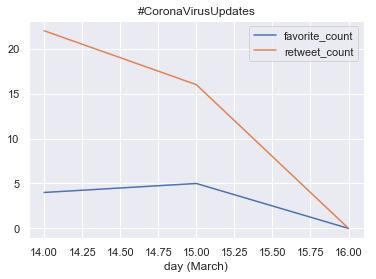

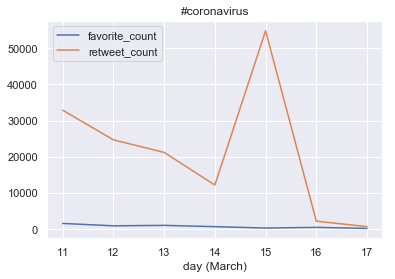

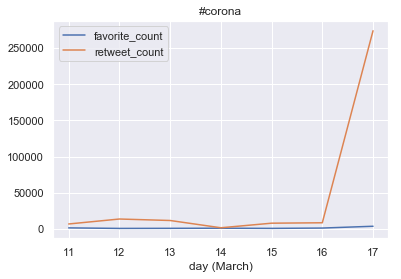

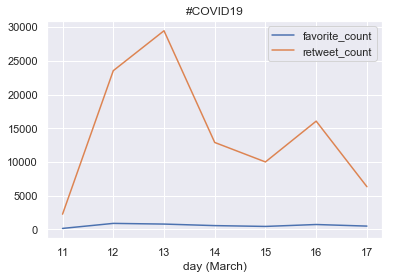

In [5]:
# take all selected columns and all numeric
cols = cols.intersection(numeric).union(selected_data)

# aggregate some selected counts
for level in df['query'].unique():
    query_counts = df[cols][df['query']==level]
    
    counts_by_day = query_counts.groupby(by=query_counts.index.day).sum()

    counts_by_day[['favorite_count', 'retweet_count']].plot()
    plt.title(f'#{level}')
    plt.xlabel('day (March)')
    plt.show()

# Load CSSE Data

Not yet implemented.

# Geolocation

Add in Ersin's script for adding the geocode here and add it to the data.

# Text analysis

Using Yuzhue's code for text analysis, mapping two new columns. Very few tweets actually have a sentiment.

In [8]:
from textblob import TextBlob

def get_sent(s, sent):
    s = TextBlob(s)
    if sent == 'polarity':
        return s.polarity
    elif sent == 'subjectivity':
        return s.subjectivity

for sent in ['polarity', 'subjectivity']:
    df[sent] = df['full_text'].apply(get_sent, sent=sent)

missing_sent = df['polarity'] == 0.0
print(f'Retrieved sentiment for {len(df) - missing_sent.sum()} out of {len(df)} tweets.')

Retrieved sentiment for 521 out of 11340 tweets.


quite visible effect here. Clear dip in polarity around the lockdown. Decreased polarity, i.e. unhappy mood. High subjectivity, i.e. divisiveness about correct approach etc.

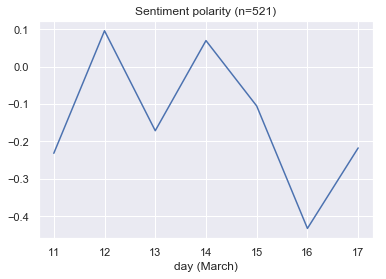

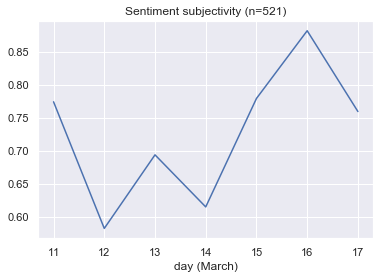

In [9]:
sentiments = df[~missing_sent]

sentiments['polarity'].groupby(sentiments.index.day).mean().plot()
plt.title(f'Sentiment polarity (n={len(sentiments)})')
plt.xlabel('day (March)')
plt.show()

sentiments['subjectivity'].groupby(sentiments.index.day).mean().plot()
plt.title(f'Sentiment subjectivity (n={len(sentiments)})')
plt.xlabel('day (March)')
plt.show()

Make word maps for most common tokens. Here, it would be very interesting to explore looking at wordmaps of broader tweet domains. I.e. look at finance or general trending to see if corona is at the forefront of public discussion 

In [71]:
lines = [list(TextBlob(line).words) for line in df['full_text'].values]
blobbyboy = TextBlob(' '.join(list(itertools.chain.from_iterable(lines))))
vocab = pd.Series(blobbyboy.word_counts).sort_values(ascending=False)

In [81]:
vocab.to_dict()

{'rt': 6564,
 'https': 5354,
 'corona': 4013,
 'eta': 2576,
 'coronavirus': 2292,
 'covid19': 1814,
 'go': 1610,
 'da': 855,
 'du': 768,
 'arteta': 651,
 'ez': 617,
 'koronabirusa': 576,
 'bat': 573,
 'bertan': 524,
 'dela': 512,
 'na': 485,
 'gara-gara': 480,
 'osasun': 470,
 'gure': 462,
 'ba': 455,
 'dugu': 446,
 'ehbildu': 436,
 't.co/gujio4dyud': 434,
 'nkmthi': 433,
 'has': 433,
 'behera': 431,
 'el': 425,
 'egoera': 422,
 'neurriak': 418,
 'aurrean': 411,
 'behar': 386,
 'euskal': 380,
 'de': 379,
 'sortutako': 346,
 'gara': 341,
 'egin': 326,
 'dute': 324,
 'dira': 318,
 'ditugu': 313,
 'koronabirusaren': 295,
 'hainbat': 294,
 'la': 270,
 '❗️': 267,
 '–': 264,
 'egiteko': 264,
 'aurre': 261,
 'mikel': 256,
 'karuna': 252,
 'te': 242,
 'ere': 241,
 'ด่วน': 235,
 'en': 235,
 'ari': 235,
 'the': 234,
 'gaur': 234,
 'utzi': 232,
 'duen': 225,
 'zaintza': 223,
 'ditu': 222,
 '🔴': 221,
 'krisi': 220,
 'neurri': 217,
 'edo': 214,
 'ezali': 211,
 'fièvre': 211,
 'kosukosu': 211,
 '⚠️'

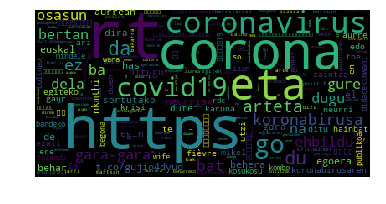

In [88]:
wordcloud = WordCloud().generate_from_frequencies(frequencies=vocab.to_dict())
plt.imshow(wordcloud)
plt.axis("off")
plt.show()